In [1]:
import os, sys
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from tqdm import tqdm
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta
from datetime import date
pd.options.mode.chained_assignment = None
import statistics
import re
import scipy.stats as stats

# 1. 导入数据

In [2]:
path = "/Users/charlesxiong/Desktop/中信证券/托管/王子豪/CTA因子数据/CTA/"
dirs = os.listdir(path)
dirs.remove('.DS_Store')
dirs

['CFuturesDeliveryWHInfo.csv',
 'CFuturesWarehouseStocks.csv',
 'CFuturesInstock.csv',
 'CFuturesHedgingPositions.csv',
 'CFuturesDelivery.csv',
 'CFuturesDeclarationOfDI.csv']

In [3]:
# 记录中国期货交易所公布的期货交割仓库基本资料，包括标准合约代码、办公地址、是否基准库等。
DeliveryWHInfo = pd.read_csv(path + str(dirs[0]))
# /Users/charlesxiong/Desktop/中信证券/托管/王子豪/CTA因子数据/CTA/CFuturesDeliveryWHInfo.csv

#记录中国期货品种的入仓、出仓、注销仓单等情况
WarehouseStocks = pd.read_csv(path + str(dirs[1]))

#记录中国期货品种的仓单库存信息
Instock = pd.read_csv(path + str(dirs[2]), encoding='gb2312')

#记录商品期货套期保值持仓数据
HedgingPositions = pd.read_csv(path + str(dirs[3]))

#记录中国期货交易所内品种的交割数据，包括交割类型、交割金额、交割结算价等。
CFuturesDelivery = pd.read_csv(path + str(dirs[4]))

#记录中国期货品种交割意向申报情况，包括会员公司ID、申报卖方交割量、申报买方交割量等。
DeclarationOfDI = pd.read_csv(path + str(dirs[5]))

In [4]:
DeliveryWHInfo

,s_info_exname,cntry_code,s_info_sccode,design_delvy_wrhs,office_address,deposit_address,contact_info,warehouse_numb,delivery_wrhs_type,bussiness_address,postcode,loading_station,agrmt_storage,delivery_zone,is_ben_wrhs,upgrade_discount,maximun_stand_wrhs,daily_delivery_speed,product_specifications,is_normal_business
0,CZCE,NaN,TA,太仓新港物流管理中心有限公司,NaN,江苏省苏州市太仓市浮桥镇北环路9号,谭彪：0512-53706207、13915790540、0512-53710890,503.0,交割仓库,NaN,215434.0,码头：太仓港,NaN,NaN,NaN,0,NaN,NaN,NaN,1.0
1,CZCE,NaN,MA,中国石化化工销售公司,NaN,江苏省无锡市江阴市澄江街道安全村安全路 68 号,吴琼：15261619771、0510-68822729,827.0,交割仓库,NaN,214429.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.0
2,CZCE,NaN,AP,栖霞德丰食品有限公司,NaN,山东省烟台市栖霞市德丰路一号,杜永斌：0535-3371789、13370927501、0535-3371769、info...,1809.0,交割厂库,NaN,265300.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1.0
3,CZCE,NaN,AP,威海市翠虹果品股份有限公司,NaN,山东省威海市荣成市城西街道办事处东岭后村,岳建东：18463166134,1831.0,交割厂库,NaN,264300.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1.0
4,SHFE,NaN,CU,国家粮食和物资储备局广东局八三0处,NaN,广东省广州市增城区永宁街创强路123号,孙建平：13168881080；陈晨：13928901955,NaN,交割仓库,NaN,NaN,NaN,NaN,NaN,NaN,标准价,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,INE,NaN,BU,中化弘润石油化工有限公司,山东省潍坊市福寿东街4461号,山东省潍坊市青州市经济开发区东京路687号,冀桂鹏：0536-8875950、15953665703、0536-8875950；马龙龙：...,NaN,交割仓库,NaN,NaN,NaN,NaN,NaN,NaN,标准价,NaN,NaN,NaN,1.0
782,DCE,NaN,A,讷河象屿农产有限公司,黑龙江省讷河工业园区,黑龙江省齐齐哈尔市讷河工业园区,崔贺：15350909099,NaN,交割仓库,NaN,161300.0,铁路：讷河站,50000.0,讷河象屿库区,0.0,-40,NaN,NaN,NaN,1.0
783,DCE,NaN,JM,中铝内蒙古国贸有限公司,NaN,内蒙古自治区巴彦淖尔市临河区五一街百替文博大厦A座10层,肖佳华：021-68903930、021-50821558、jh_xiao@chalco.c...,NaN,交割仓库,NaN,15000.0,铁路：沙河驿站,60000.0,迁安市晟驿物流有限公司和迁安市晟恩物流有限公司,1.0,0,NaN,NaN,NaN,1.0
784,DCE,NaN,C,陕西粮农集团有限责任公司,内蒙古通辽市开鲁县义和塔拉镇核心村,内蒙古自治区通辽市开鲁县义和塔拉镇核心村,王换萍：13363910986；许海鹏：13659197966,NaN,交割仓库,NaN,28414.0,铁路：平安地站,50000.0,陕粮农开鲁库区,0.0,-100,NaN,NaN,NaN,1.0


# 2. 处理仓单 ‘Instock’ 数据

In [50]:
in_stock = Instock.pivot(index = 'ANN_DATE', columns = ['FS_INFO_SCNAME'], values = 'IN_STOCK').reset_index()

#values = 'IN_STOCK' 是库存（注册成仓单）
in_stock.head(5)

FS_INFO_SCNAME,ANN_DATE,20号胶,一号棉花,不锈钢,中密度纤维板,中质含硫原油,乙二醇,优质强筋小麦,低硫燃料油,冶金焦炭,...,锡,锰硅,镍,阴极铜,鲜苹果,鲜鸡蛋,黄大豆1号,黄大豆2号,黄玉米,黄金
0,20100104,NaN,1907.0,NaN,NaN,NaN,NaN,4337.0,NaN,NaN,...,NaN,NaN,NaN,32390.0,NaN,NaN,342.0,NaN,7.0,477.0
1,20100105,NaN,1973.0,NaN,NaN,NaN,NaN,4337.0,NaN,NaN,...,NaN,NaN,NaN,33015.0,NaN,NaN,342.0,NaN,7.0,396.0
2,20100106,NaN,2205.0,NaN,NaN,NaN,NaN,4337.0,NaN,NaN,...,NaN,NaN,NaN,33989.0,NaN,NaN,342.0,NaN,7.0,396.0
3,20100107,NaN,2619.0,NaN,NaN,NaN,NaN,4337.0,NaN,NaN,...,NaN,NaN,NaN,33840.0,NaN,NaN,342.0,NaN,7.0,345.0
4,20100108,NaN,2738.0,NaN,NaN,NaN,NaN,4337.0,NaN,NaN,...,NaN,NaN,NaN,33715.0,NaN,NaN,342.0,NaN,7.0,345.0


# 3. 期货价格处理
### 以主力合约涨跌幅作为期货价格变化率的参考

In [51]:
price2017 = pd.read_csv('/Users/charlesxiong/Desktop/中信证券/托管/王子豪/CTA数据/CCommodityFuturesEODPrices.csv')
price2020 = pd.read_csv('/Users/charlesxiong/Desktop/中信证券/托管/王子豪/moreCTA因子/CCommodityFuturesEODPrices.csv')
price = pd.concat([price2017, price2020])  #把两个时间段的数据整合起来
code = pd.read_csv('/Users/charlesxiong/Desktop/中信证券/托管/王子豪/CTA数据/CFuturesDescription.csv') 
code = code[['s_info_windcode','fs_info_sccode','s_info_name']]
price_code = pd.merge(price, code, on = 's_info_windcode', how = 'left')

In [52]:
#获得主力合约收盘价时间序列
main = price_code[price_code.fs_info_type == 1]

#s_info_windcode包含“_S”后缀的是次主力合约，剔除
main = main[main['s_info_windcode'].str.match('.*_S.') == False]
main_price = main.pivot(index = 'trade_dt', columns = 'fs_info_sccode', values = 's_dq_close').reset_index()

#该表格包含不同货品期货主力合约的价格
main_price.head(5)

fs_info_sccode,trade_dt,A,AF-S,AG,AL,AP,AU,B,BB,BC,...,SR,SS,TA,UR,V,WH,WR,Y,ZC,ZN
0,20170103,4217.0,72.0,4078.0,12630.0,NaN,269.75,4004.0,85.00,NaN,...,6739.0,NaN,5446.0,NaN,6025.0,2990.0,2353.0,6950.0,493.0,21045.0
1,20170104,4285.0,72.0,4130.0,12680.0,NaN,270.40,4030.0,89.65,NaN,...,6808.0,NaN,5386.0,NaN,6135.0,2992.0,2353.0,6880.0,496.8,21180.0
2,20170105,4260.0,72.0,4137.0,12595.0,NaN,269.50,4188.0,94.65,NaN,...,6847.0,NaN,5342.0,NaN,6125.0,2989.0,2353.0,6874.0,509.6,21355.0
3,20170106,4267.0,72.0,4075.0,12510.0,NaN,268.85,4188.0,95.00,NaN,...,6791.0,NaN,5352.0,NaN,6135.0,2987.0,2353.0,6800.0,508.0,21215.0
4,20170109,4211.0,72.0,4109.0,12580.0,NaN,269.75,4120.0,103.60,NaN,...,6836.0,NaN,5376.0,NaN,6380.0,3001.0,2353.0,6824.0,517.4,21775.0


# 4. 整理数据

## 4.1 处理 main_price（主力合约价格） 表格的表头

In [53]:
#将 main_price 表格的 fs_info_sccode 转化为 FS_INFO_SCNAME
# https://github.com/akfamily/akshare/blob/main/docs/data/futures/futures.md
wind_code = pd.read_csv('/Users/charlesxiong/Desktop/中信证券/托管/王子豪/moreCTA因子/FuturesExchangeproductcode.csv')
wind_code['fs_info_sccode'] = wind_code['s_info_windcode'].str.split(r'[0-9]+')
wind_code['FS_INFO_SCNAME'] = wind_code['business_abbreviation'].str.split(r'[0-9]+合约')
code_dict = {wind_code.fs_info_sccode[i][0] : wind_code.FS_INFO_SCNAME[i][0] for i in range(wind_code.shape[0])}
inverse_dict = {wind_code.FS_INFO_SCNAME[i][0] : wind_code.fs_info_sccode[i][0] for i in range(wind_code.shape[0])}

#把菜籽油从dicto里删掉，因为RO OI都代表菜籽油，影响后续判断
inverse_dict.pop('菜籽油')
code_dict.pop('RO')
code_dict.pop('OI')

'菜籽油'

In [161]:
code_dict

{'RR': '粳米',
 'M': '豆粕',
 'Y': '大豆原油',
 'FB': '纤维板',
 'BB': '细木工板',
 'I': '铁矿石',
 'JM': '焦煤',
 'L': '线型低密度聚乙烯',
 'P': '棕榈油',
 'PP': '聚丙烯',
 'V': '聚氯乙烯',
 'B': '黄大豆2号',
 'J': '冶金焦炭',
 'SN': '锡',
 'NI': '镍',
 'ZN': '锌',
 'AL': '铝',
 'CU': '铜',
 'HC': '热轧卷板',
 'RB': '螺纹钢',
 'AG': '白银',
 'PB': '铅',
 'WR': '线材',
 'SP': '漂白硫酸盐针叶木浆',
 'RU': '天然橡胶',
 'BU': '石油沥青',
 'AU': '黄金',
 'NR': '20号胶',
 'IM_S': '上期有色金属指数期货',
 'JD': '鲜鸡蛋',
 'EG': '乙二醇',
 'SC': '中质含硫原油',
 'FU': '燃料油',
 'A': '黄大豆1号',
 'C': '黄玉米',
 'CS': '玉米淀粉',
 'SS': '不锈钢',
 'mAu(T+D).SGE': 'SGEMini黄金T+D',
 'EB': '苯乙烯',
 'PG': '液化石油气(LPG)',
 'iAu': 'SGE国际版黄金9999',
 'Ag(T+D).SGE': 'SGE白银T+D',
 'Ag': 'SGE白银9999',
 'Pt': 'SGE铂金9995',
 'Au(T+N': 'SGE黄金T+N2',
 'Au': 'SGE黄金9999',
 'Au(T+D).SGE': 'SGE黄金T+D',
 'IC': '中证500期货',
 'IH': '上证50期货',
 'IF': '沪深300期货',
 'PK': '花生仁',
 'PF': '涤纶短纤',
 'WH': '强麦',
 'UR': '尿素',
 'TA': '精对苯二甲酸(PTA)',
 'SR': '白砂糖',
 'SM': '锰硅',
 'SF': '硅铁',
 'SA': '纯碱',
 'RM': '菜籽粕',
 'RI': '早籼稻',
 'PM': '普麦',
 'MA': '甲醇',
 'LR'

In [54]:
# 处理 main_price 表格的表头，将其改为中文名称，并且删除字典中没有对照的columns
def select_columns(data, dictionary):
    new_col = []
    rm = []
    for k in data.columns:
        try:
            col = dictionary[k]
            new_col.append(col)
        except KeyError:
            new_col.append(k)
            if k != 'trade_dt':
                rm.append(k)   #对于字典中找不到的货品种类，直接删除一整个column
    data.columns = new_col
    return data.drop(rm, 1)

In [55]:
s_main_price = select_columns(main_price, code_dict)

In [56]:
s_main_price

,trade_dt,黄大豆1号,白银,铝,鲜苹果,黄金,黄大豆2号,细木工板,国际铜,石油沥青,...,白砂糖,不锈钢,精对苯二甲酸(PTA),尿素,聚氯乙烯,强麦,线材,大豆原油,动力煤,锌
0,20170103,4217.0,4078.0,12630.0,NaN,269.75,4004.0,85.00,NaN,2648.0,...,6739.0,NaN,5446.0,NaN,6025.0,2990.0,2353.0,6950.0,493.0,21045.0
1,20170104,4285.0,4130.0,12680.0,NaN,270.40,4030.0,89.65,NaN,2654.0,...,6808.0,NaN,5386.0,NaN,6135.0,2992.0,2353.0,6880.0,496.8,21180.0
2,20170105,4260.0,4137.0,12595.0,NaN,269.50,4188.0,94.65,NaN,2646.0,...,6847.0,NaN,5342.0,NaN,6125.0,2989.0,2353.0,6874.0,509.6,21355.0
3,20170106,4267.0,4075.0,12510.0,NaN,268.85,4188.0,95.00,NaN,2678.0,...,6791.0,NaN,5352.0,NaN,6135.0,2987.0,2353.0,6800.0,508.0,21215.0
4,20170109,4211.0,4109.0,12580.0,NaN,269.75,4120.0,103.60,NaN,2712.0,...,6836.0,NaN,5376.0,NaN,6380.0,3001.0,2353.0,6824.0,517.4,21775.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,20221226,5175.0,5326.0,18715.0,7877.0,407.24,5035.0,400.00,58900.0,3735.0,...,5766.0,16540.0,5432.0,2483.0,6285.0,NaN,4775.0,8514.0,NaN,23520.0
1455,20221227,5169.0,5387.0,19105.0,7911.0,407.96,5137.0,400.00,59360.0,3812.0,...,5826.0,16735.0,5496.0,2497.0,6333.0,3260.0,4847.0,8794.0,NaN,23810.0
1456,20221228,5202.0,5356.0,18785.0,7853.0,408.60,5127.0,400.00,59240.0,3843.0,...,5731.0,16715.0,5492.0,2488.0,6306.0,NaN,4805.0,8838.0,NaN,23965.0
1457,20221229,5168.0,5286.0,18685.0,7865.0,408.36,5142.0,400.00,59360.0,3834.0,...,5773.0,16800.0,5488.0,2516.0,6257.0,3394.0,4732.0,8826.0,NaN,23800.0


## 4.2 处理 IS_grange（仓单数据）表头。保证 仓单数据 和 主力合约收益率数据 表头、时间段、时间频率一致性

In [57]:
#找出同时段的仓单变化数据
#日度转化为周度数据，该表格包括不同货品仓单量（周度）
IS = in_stock[(in_stock['ANN_DATE'] >= min(main_price.trade_dt)) & (in_stock['ANN_DATE'] <= max(main_price.trade_dt))]
IS.head(5)

FS_INFO_SCNAME,ANN_DATE,20号胶,一号棉花,不锈钢,中密度纤维板,中质含硫原油,乙二醇,优质强筋小麦,低硫燃料油,冶金焦炭,...,锡,锰硅,镍,阴极铜,鲜苹果,鲜鸡蛋,黄大豆1号,黄大豆2号,黄玉米,黄金
1700,20170103,NaN,1399.0,NaN,NaN,NaN,NaN,1185.0,NaN,NaN,...,722.0,2.0,87543.0,46601.0,NaN,NaN,24939.0,NaN,288.0,930.0
1701,20170104,NaN,1427.0,NaN,NaN,NaN,NaN,1560.0,NaN,NaN,...,722.0,2.0,86827.0,46799.0,NaN,NaN,24973.0,NaN,1288.0,930.0
1702,20170105,NaN,1474.0,NaN,NaN,NaN,NaN,2200.0,NaN,NaN,...,716.0,2.0,84942.0,47301.0,NaN,NaN,25317.0,NaN,1288.0,930.0
1703,20170106,NaN,1482.0,NaN,NaN,NaN,NaN,1979.0,NaN,NaN,...,702.0,2.0,83988.0,49092.0,NaN,NaN,26690.0,NaN,1917.0,930.0
1704,20170109,NaN,1529.0,NaN,NaN,NaN,NaN,1979.0,NaN,NaN,...,698.0,2.0,83664.0,48992.0,NaN,NaN,27690.0,NaN,3317.0,930.0


In [58]:
## 处理两个表格的 NaN 和 0 数据

# 将NaN太多的列删除
# 周度数据量本身不多，选取nan个数在nan_control个以内的货品数据
nan_control = 0

# 符合条件的货品在两个表格中分别有sum(IS_nan), sum(main_nan)个
IS_nan = IS.set_index('ANN_DATE').isna().sum(axis=0) <= nan_control
main_nan = s_main_price.set_index('trade_dt').isna().sum(axis=0) <= nan_control

sum(IS_nan), sum(main_nan)

(30, 35)

In [59]:
#获取两个表格中符合条件的货品的交集
nan1 = []
nan2 = []

for i in range(len(IS_nan)):
    if IS_nan.values[i]:
        nan1.append(IS_nan.index[i])
for i in range(len(main_nan)):
    if main_nan.values[i]:
        nan2.append(main_nan.index[i])
both_product = list(set(nan1) & set(nan2))

#获得两个表格的交集
#现在，两个表格中的货品种类，数据频率，时间段均一致。
s_IS = IS.set_index('ANN_DATE')[both_product].iloc[1:].reset_index()
s_main = s_main_price.set_index('trade_dt')[both_product].iloc[1:].reset_index()

In [60]:
s_IS

FS_INFO_SCNAME,ANN_DATE,石油沥青,螺纹钢,锡,铝,热轧卷板,镍,白银,菜籽粕,锌,白砂糖,平板玻璃,铅,天然橡胶,黄金,一号棉花,精对苯二甲酸(PTA),甲醇,锰硅
0,20170104,284070.0,3011.0,722.0,28750.0,0.0,86827.0,1863038.0,2900.0,82315.0,39315.0,688.0,20418.0,238080.0,930.0,1427.0,204987.0,0.0,2.0
1,20170105,282370.0,3011.0,716.0,28449.0,0.0,84942.0,1861786.0,3500.0,79173.0,40717.0,688.0,20418.0,239280.0,930.0,1474.0,205047.0,0.0,2.0
2,20170106,286420.0,2421.0,702.0,28197.0,0.0,83988.0,1870994.0,3500.0,75222.0,48222.0,688.0,20368.0,240370.0,930.0,1482.0,204857.0,700.0,2.0
3,20170109,284280.0,2421.0,698.0,27618.0,0.0,83664.0,1874493.0,5100.0,76016.0,57914.0,688.0,22005.0,242940.0,930.0,1529.0,205681.0,700.0,2.0
4,20170110,284510.0,2421.0,1834.0,27241.0,0.0,83728.0,1875955.0,5100.0,74943.0,58431.0,701.0,22357.0,243280.0,927.0,1583.0,213743.0,710.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,20221226,26270.0,0.0,4097.0,35592.0,21379.0,1098.0,2061533.0,0.0,528.0,3555.0,1075.0,30008.0,157740.0,3339.0,1996.0,14720.0,2880.0,3988.0
1454,20221227,26270.0,0.0,4151.0,35592.0,21379.0,1145.0,2072862.0,0.0,427.0,6486.0,1025.0,28176.0,159020.0,3339.0,2082.0,14720.0,2505.0,3656.0
1455,20221228,26270.0,0.0,4230.0,35492.0,21379.0,1145.0,2080412.0,0.0,427.0,6606.0,1025.0,28454.0,162120.0,3339.0,2105.0,14520.0,2505.0,3656.0
1456,20221229,26270.0,0.0,4397.0,32741.0,21083.0,1145.0,2126769.0,0.0,427.0,9979.0,1025.0,29642.0,163620.0,3339.0,2448.0,14294.0,2505.0,3605.0


In [61]:
s_main = s_main.rename(columns = {'trade_dt':'ANN_DATE'})
s_main

,ANN_DATE,石油沥青,螺纹钢,锡,铝,热轧卷板,镍,白银,菜籽粕,锌,白砂糖,平板玻璃,铅,天然橡胶,黄金,一号棉花,精对苯二甲酸(PTA),甲醇,锰硅
0,20170104,2654.0,2930.0,150720.0,12680.0,3370.0,85130.0,4130.0,2310.0,21180.0,6808.0,1208.0,17715.0,18530.0,270.40,15085.0,5386.0,2670.0,6492.0
1,20170105,2646.0,2941.0,154930.0,12595.0,3358.0,85250.0,4137.0,2301.0,21355.0,6847.0,1211.0,17910.0,18075.0,269.50,15300.0,5342.0,2661.0,6456.0
2,20170106,2678.0,2912.0,152900.0,12510.0,3273.0,84810.0,4075.0,2296.0,21215.0,6791.0,1206.0,17960.0,17855.0,268.85,15185.0,5352.0,2646.0,6360.0
3,20170109,2712.0,3048.0,153260.0,12580.0,3449.0,86370.0,4109.0,2290.0,21775.0,6836.0,1228.0,18090.0,18970.0,269.75,15370.0,5376.0,2716.0,6322.0
4,20170110,2666.0,3167.0,154800.0,12870.0,3562.0,87130.0,4126.0,2291.0,22555.0,6811.0,1277.0,18755.0,19270.0,271.50,15445.0,5334.0,2713.0,6360.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,20221226,3735.0,4006.0,197940.0,18715.0,4048.0,218690.0,5326.0,3134.0,23520.0,5766.0,1577.0,15980.0,12645.0,407.24,14025.0,5432.0,2498.0,7470.0
1454,20221227,3812.0,4066.0,205050.0,19105.0,4092.0,227750.0,5387.0,3157.0,23810.0,5826.0,1629.0,16120.0,12800.0,407.96,14220.0,5496.0,2550.0,7488.0
1455,20221228,3843.0,4050.0,209270.0,18785.0,4077.0,228250.0,5356.0,3135.0,23965.0,5731.0,1656.0,16185.0,12815.0,408.60,14230.0,5492.0,2566.0,7458.0
1456,20221229,3834.0,4048.0,207690.0,18685.0,4090.0,228890.0,5286.0,3153.0,23800.0,5773.0,1647.0,15905.0,12685.0,408.36,14180.0,5488.0,2568.0,7646.0


## 4.4 合并数据

In [62]:
# 将main_clean和IS_clean进行合并
# columns = 日期，货品种类，期货收益率，仓单变化率分组

#期货价格
price_unpivot = pd.melt(s_main, id_vars = 'ANN_DATE', var_name='FS_INFO_SCNAME', value_name='PRICE_VALUE')
#仓单数据
IS_unpivot = pd.melt(s_IS, id_vars = 'ANN_DATE', var_name='FS_INFO_SCNAME', value_name='IN_STOCK')


final_data = price_unpivot.merge(IS_unpivot, on = ['ANN_DATE', 'FS_INFO_SCNAME'])

In [63]:
# 找到commodity对应的id
commodity_all = list(final_data.FS_INFO_SCNAME)
commodity_id_all = []

# 加入fs_info_sccode列
for i in commodity_all:
    commodity_id_all.append(inverse_dict[i])
final_data['fs_info_sccode'] = commodity_id_all

final_data

,ANN_DATE,FS_INFO_SCNAME,PRICE_VALUE,IN_STOCK,fs_info_sccode
0,20170104,石油沥青,2654.0,284070.0,BU
1,20170105,石油沥青,2646.0,282370.0,BU
2,20170106,石油沥青,2678.0,286420.0,BU
3,20170109,石油沥青,2712.0,284280.0,BU
4,20170110,石油沥青,2666.0,284510.0,BU
...,...,...,...,...,...
26239,20221226,锰硅,7470.0,3988.0,SM
26240,20221227,锰硅,7488.0,3656.0,SM
26241,20221228,锰硅,7458.0,3656.0,SM
26242,20221229,锰硅,7646.0,3605.0,SM


# 5. 主力合约拼接

## 5.1 数据处理：找出每期主力合约代号

### CfuturesContractMapping.csv 数据中包含了所有货品每期主力合约的映射合约以及它们的时间段。此处做拼接的方法是“向前比例调整”，通过缩放价格曲线来拼接（参考：https://zhuanlan.zhihu.com/p/51880559 2.4向前和向后比例调整）

### 具体做法为：假设主力合约$f_a$在T = [t0, t1]时刻的价格为$P_{a,T=[t_0,t_1]}$，主力合约为$f_b$在T = [t2, t3]时刻的价格为$P_{b,T=[t_2,t_3]}$，t2为t1的下一个交易日。价格跳变是由于$P_{a,T=t_2}$和$P_{b,T=t_2}$的差异带来，会影响收益率的准确计算。所以求出价格调整乘数$d = P_{b,T=t_2} / P_{a,T=t_2}$，得出新的价格序列$d * P_{i,T=[0,t_1]}$，从而平滑t1至t2时刻的价格跳变（i为[0,t1]中每一期的主力合约）。以此类推，从最后一期的主力合约向前进行价格调整。

In [64]:
mapping = pd.read_csv('/Users/charlesxiong/Desktop/中信证券/托管/王子豪/CTA数据/CfuturesContractMapping.csv')
main_mapping = mapping[mapping['s_info_windcode'].str.match(r'.*_S.|.*[0-9].*') == False]
#fs_lastmain_windcode 代表上一期主力合约的代码
main_mapping['fs_lastmain_windcode'] = main_mapping.sort_values(
    by = 'startdate').groupby('s_info_windcode')['fs_mapping_windcode'].shift(1)
main_mapping

,object_id,s_info_windcode,fs_mapping_windcode,startdate,enddate,contract_id,opdate,opmode,fs_lastmain_windcode
37,{EB4B2B45-28C6-AACD-E053-1F01C80A155C},A.DCE,A2301.DCE,20221019,20221213,SzIZsyPPmb,2022-12-12 16:10:42,0,A2211.DCE
162,{F0DFC51C-B954-8AAB-E053-1F01C80A450E},B.DCE,B2302.DCE,20221229,20230118,BhYhb2aBJA,2023-01-17 16:22:09,0,B2301.DCE
167,{F0DFC51C-B95C-8AAB-E053-1F01C80A450E},BC.INE,BC2303.INE,20221229,20230201,8x1S4Mh6T3,2023-01-31 16:34:39,0,BC2302.INE
171,{F066C2D6-BD64-D350-E053-1F01C80AD305},PG.DCE,PG2302.DCE,20221223,20230117,jLsfZHJROB,2023-01-16 16:27:22,0,PG2301.DCE
174,{EF26092D-9F21-ACD2-E053-2001C80ABB03},SCO.INE,SC2302.INE,20221207,20221228,OR7DdcSkTW,2022-12-27 17:00:33,0,SC2301.INE
...,...,...,...,...,...,...,...,...,...
50121,{F8F89B7A-31EB-75CA-E053-2001C80AEEEA},VO.DCE,V2309.DCE,20230411,20230414,j262a1TnM1,2023-04-13 17:00:36,0,V2305.DCE
50122,{F8F89B7A-31EC-75CA-E053-2001C80AEEEA},PPO.DCE,PP2309.DCE,20230411,20230414,7bHfSecN1m,2023-04-13 17:00:36,0,PP2305.DCE
50123,{F8F89B7A-31ED-75CA-E053-2001C80AEEEA},YO.DCE,Y2309.DCE,20230411,20230414,FLvcdnXNow,2023-04-13 17:00:37,0,Y2305.DCE
50124,{F8F89B7A-31EE-75CA-E053-2001C80AEEEA},BO.DCE,B2307.DCE,20230411,20230411,BhYhb2aBJA,2023-04-10 17:00:35,0,B2305.DCE


In [65]:
# 通过regex找出主力合约代号
k = main_mapping['s_info_windcode'].str.split(r'\.')
fs_sccode = [i[0] for i in k]
main_mapping['fs_info_sccode'] = fs_sccode
past_df = main_mapping[['startdate', 'fs_mapping_windcode', 'fs_info_sccode', 'fs_lastmain_windcode']]
#将startdate转化为ANN_DATE，意味着此时每个日期都是主力合约的起始日
past_df = past_df.rename(columns = {'startdate':'ANN_DATE', 'fs_lastmain_windcode':'s_info_windcode'})
past_df

#移除多余的货品类别
fs_list = list(final_data.fs_info_sccode.unique())
past_df = past_df[past_df['fs_info_sccode'].isin(fs_list)]
past_df


,ANN_DATE,fs_mapping_windcode,fs_info_sccode,s_info_windcode
304,20221122,PB2301.SHF,PB,PB2212.SHF
456,20221027,PB2212.SHF,PB,PB2211.SHF
491,20220929,NI2211.SHF,NI,NI2210.SHF
511,20221129,NI2301.SHF,NI,NI2212.SHF
570,20221115,AU2302.SHF,AU,AU2212.SHF
...,...,...,...,...
49894,20230411,FG309.CZC,FG,FG305.CZC
49896,20230411,TA309.CZC,TA,TA305.CZC
49972,20230406,HC2310.SHF,HC,HC2305.SHF
49976,20230406,RB2310.SHF,RB,RB2305.SHF


In [66]:
# 通过数据合并找出当期的旧主力合约的价格
# 这一步得到 t2 时的前期主力合约f1的价格p_a_t2
real = price_code[price_code['fs_info_type'] == 2]
real = real.rename(columns = {'trade_dt':'ANN_DATE'})
past_price = pd.merge(past_df, real, on = ['ANN_DATE', 's_info_windcode','fs_info_sccode'], how = 'left')
past_price = past_price[['ANN_DATE', 'fs_mapping_windcode','s_info_windcode','fs_info_sccode','s_dq_close']]
past_price = past_price.rename(columns={'s_info_windcode':'past_sccode'
                                        ,'fs_mapping_windcode':'s_info_windcode'})
past_price

,ANN_DATE,s_info_windcode,past_sccode,fs_info_sccode,s_dq_close
0,20221122,PB2301.SHF,PB2212.SHF,PB,15700.00
1,20221027,PB2212.SHF,PB2211.SHF,PB,15100.00
2,20220929,NI2211.SHF,NI2210.SHF,NI,182970.00
3,20221129,NI2301.SHF,NI2212.SHF,NI,197800.00
4,20221115,AU2302.SHF,AU2212.SHF,AU,404.68
...,...,...,...,...,...
550,20230411,FG309.CZC,FG305.CZC,FG,NaN
551,20230411,TA309.CZC,TA305.CZC,TA,NaN
552,20230406,HC2310.SHF,HC2305.SHF,HC,NaN
553,20230406,RB2310.SHF,RB2305.SHF,RB,NaN


In [67]:
# 找出当期新主力合约的价格
# 这一步得到 t2时 当期主力合约f2的价格p_b_t2
match_price = pd.merge(final_data, past_price, on = ['ANN_DATE', 'fs_info_sccode'], how = 'left')
match_price

,ANN_DATE,FS_INFO_SCNAME,PRICE_VALUE,IN_STOCK,fs_info_sccode,s_info_windcode,past_sccode,s_dq_close
0,20170104,石油沥青,2654.0,284070.0,BU,NaN,NaN,NaN
1,20170105,石油沥青,2646.0,282370.0,BU,NaN,NaN,NaN
2,20170106,石油沥青,2678.0,286420.0,BU,NaN,NaN,NaN
3,20170109,石油沥青,2712.0,284280.0,BU,NaN,NaN,NaN
4,20170110,石油沥青,2666.0,284510.0,BU,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
26239,20221226,锰硅,7470.0,3988.0,SM,NaN,NaN,NaN
26240,20221227,锰硅,7488.0,3656.0,SM,NaN,NaN,NaN
26241,20221228,锰硅,7458.0,3656.0,SM,NaN,NaN,NaN
26242,20221229,锰硅,7646.0,3605.0,SM,NaN,NaN,NaN


## 5.2 价格平滑处理

In [68]:
# 获得价格除数factor：p_b_t2 / p_a_t2 = d 
match_price['factor'] = match_price.PRICE_VALUE / match_price.s_dq_close
match_price

,ANN_DATE,FS_INFO_SCNAME,PRICE_VALUE,IN_STOCK,fs_info_sccode,s_info_windcode,past_sccode,s_dq_close,factor
0,20170104,石油沥青,2654.0,284070.0,BU,NaN,NaN,NaN,NaN
1,20170105,石油沥青,2646.0,282370.0,BU,NaN,NaN,NaN,NaN
2,20170106,石油沥青,2678.0,286420.0,BU,NaN,NaN,NaN,NaN
3,20170109,石油沥青,2712.0,284280.0,BU,NaN,NaN,NaN,NaN
4,20170110,石油沥青,2666.0,284510.0,BU,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
26239,20221226,锰硅,7470.0,3988.0,SM,NaN,NaN,NaN,NaN
26240,20221227,锰硅,7488.0,3656.0,SM,NaN,NaN,NaN,NaN
26241,20221228,锰硅,7458.0,3656.0,SM,NaN,NaN,NaN,NaN
26242,20221229,锰硅,7646.0,3605.0,SM,NaN,NaN,NaN,NaN


In [69]:
# 将之前f_a的价格整体乘 d, 以此类推，此处代表d的变量为factor列
# 按照逻辑应该向上填补factor列的NaN，因为合并前ANN_DATE代表每个主力合约s_info_windcode的起始日(t_2)
# 同理，向下填补s_info_windcode列的NaN
match_price['factor'] = match_price.sort_values(by="ANN_DATE").groupby('fs_info_sccode')['factor'].bfill()
match_price['s_info_windcode'] = match_price.sort_values(by="ANN_DATE").groupby('fs_info_sccode')['s_info_windcode'].ffill()
# factor列剩下的NaN存在是因为没有进行向上填补，这些NaN所对应的真实值就是1，因为它们是最新一期的主力合约数据，无需进行价格拼接
# d = p2_n / p2_n = 1
match_price['factor'] = match_price['factor'].fillna(1)
match_price

,ANN_DATE,FS_INFO_SCNAME,PRICE_VALUE,IN_STOCK,fs_info_sccode,s_info_windcode,past_sccode,s_dq_close,factor
0,20170104,石油沥青,2654.0,284070.0,BU,NaN,NaN,NaN,1.035878
1,20170105,石油沥青,2646.0,282370.0,BU,NaN,NaN,NaN,1.035878
2,20170106,石油沥青,2678.0,286420.0,BU,NaN,NaN,NaN,1.035878
3,20170109,石油沥青,2712.0,284280.0,BU,NaN,NaN,NaN,1.035878
4,20170110,石油沥青,2666.0,284510.0,BU,NaN,NaN,NaN,1.035878
...,...,...,...,...,...,...,...,...,...
26239,20221226,锰硅,7470.0,3988.0,SM,SM305.CZC,NaN,NaN,1.000000
26240,20221227,锰硅,7488.0,3656.0,SM,SM305.CZC,NaN,NaN,1.000000
26241,20221228,锰硅,7458.0,3656.0,SM,SM305.CZC,NaN,NaN,1.000000
26242,20221229,锰硅,7646.0,3605.0,SM,SM305.CZC,NaN,NaN,1.000000


In [70]:
## 计算累计缩放的比例，假设每一期相对下一期的缩放比例为[0.9, 0.88, 0.92]
## 那么累计缩放的比例为[0.9*0.88*0.92, 0.88*0.92, 0.92]

# 识别出一个list中每次值的变化
# 例如输入[1,1,1,2,2,3,1,1,1,1,4] -> return [1,2,3,1,4]
def find_changing_values(ls):
    l = [list(ls)[0]]
    for i in range(1, len(ls)):
        if ls[i] != ls[i-1]:
            l.append(ls[i])
    return l

# 向前比例调整 需要缩放每个主力合约的价格曲线，缩放幅度是每次计算出di的累计值 D = d1*d2*d3*...*dn 
# prod_backward()可以返回每一期主力合约价格从后向前所需平移的累计幅度
def prod_backward(ls):
    ls = list(ls)
    unique = np.array(find_changing_values(ls))
    reverse = unique[::-1].cumprod()[::-1]  #从后往前，计算每一段主力合约价格所需乘上的cumulative product
    cumu = [reverse[0]]
    k = 0
    for i in range(1,len(ls)):
        if ls[i] == ls[i-1]:
            cumu.append(reverse[k])
        else:
            k = k + 1
            cumu.append(reverse[k])
    cumu.append(1)
    return cumu[1:]

In [71]:
#计算平滑/拼接后的价格
fs_list = list(match_price.fs_info_sccode.unique())
smooth = pd.DataFrame()
for i in fs_list:
    single = match_price[match_price.fs_info_sccode == i]
    single['cumu_factor'] = prod_backward(single['factor'])
    single['smooth_price'] = single['cumu_factor'] * single['PRICE_VALUE']
    smooth = pd.concat([smooth, single], axis = 0)

In [72]:
finished_data = smooth
finished_data['ANN_DATE'] = pd.to_datetime(finished_data['ANN_DATE'], format='%Y%m%d', errors='coerce')
finished_data

,ANN_DATE,FS_INFO_SCNAME,PRICE_VALUE,IN_STOCK,fs_info_sccode,s_info_windcode,past_sccode,s_dq_close,factor,cumu_factor,smooth_price
0,2017-01-04,石油沥青,2654.0,284070.0,BU,NaN,NaN,NaN,1.035878,1.271373,3374.224713
1,2017-01-05,石油沥青,2646.0,282370.0,BU,NaN,NaN,NaN,1.035878,1.271373,3364.053727
2,2017-01-06,石油沥青,2678.0,286420.0,BU,NaN,NaN,NaN,1.035878,1.271373,3404.737672
3,2017-01-09,石油沥青,2712.0,284280.0,BU,NaN,NaN,NaN,1.035878,1.271373,3447.964364
4,2017-01-10,石油沥青,2666.0,284510.0,BU,NaN,NaN,NaN,1.035878,1.271373,3389.481193
...,...,...,...,...,...,...,...,...,...,...,...
26239,2022-12-26,锰硅,7470.0,3988.0,SM,SM305.CZC,NaN,NaN,1.000000,1.000000,7470.000000
26240,2022-12-27,锰硅,7488.0,3656.0,SM,SM305.CZC,NaN,NaN,1.000000,1.000000,7488.000000
26241,2022-12-28,锰硅,7458.0,3656.0,SM,SM305.CZC,NaN,NaN,1.000000,1.000000,7458.000000
26242,2022-12-29,锰硅,7646.0,3605.0,SM,SM305.CZC,NaN,NaN,1.000000,1.000000,7646.000000


# 5.3 平滑前 vs 平滑后（验证）

In [73]:
past_price['ANN_DATE'] = pd.to_datetime(past_price['ANN_DATE'], format='%Y%m%d', errors='coerce')
past_price = past_price.drop(['s_info_windcode'],1)
past_price = past_price.rename(columns = {'s_dq_close':'PRICE_VALUE', 'past_sccode':'s_info_windcode'})
A = pd.concat([finished_data, past_price])
code = list(A.s_info_windcode.unique())
single_o = pd.DataFrame()
for i in code:
    single = A[A['s_info_windcode'] == i].sort_values(by = ['ANN_DATE'])
    single['new_cumu'] = single['cumu_factor'].fillna(method="ffill")
    single['smooth_price'] = single['new_cumu'] * single['PRICE_VALUE']
    single_o = pd.concat([single_o, single])

In [145]:
# 以某一货品为例画图
# 从拼接结果来看是和预期相符的，说明finished_data可以使用
AG = single_o[single_o.fs_info_sccode == 'SM']
AG = AG[(AG['ANN_DATE'] > '2017-12-31') & (AG['ANN_DATE'] < '2020-7-31')]
AG_P = AG.pivot(index = 'ANN_DATE', columns = 's_info_windcode', values = 'PRICE_VALUE')
AG_S = AG.pivot(index = 'ANN_DATE', columns = 's_info_windcode', values = 'smooth_price')

Text(0.5, 1.0, 'Front Month Contract - Before Continuation')

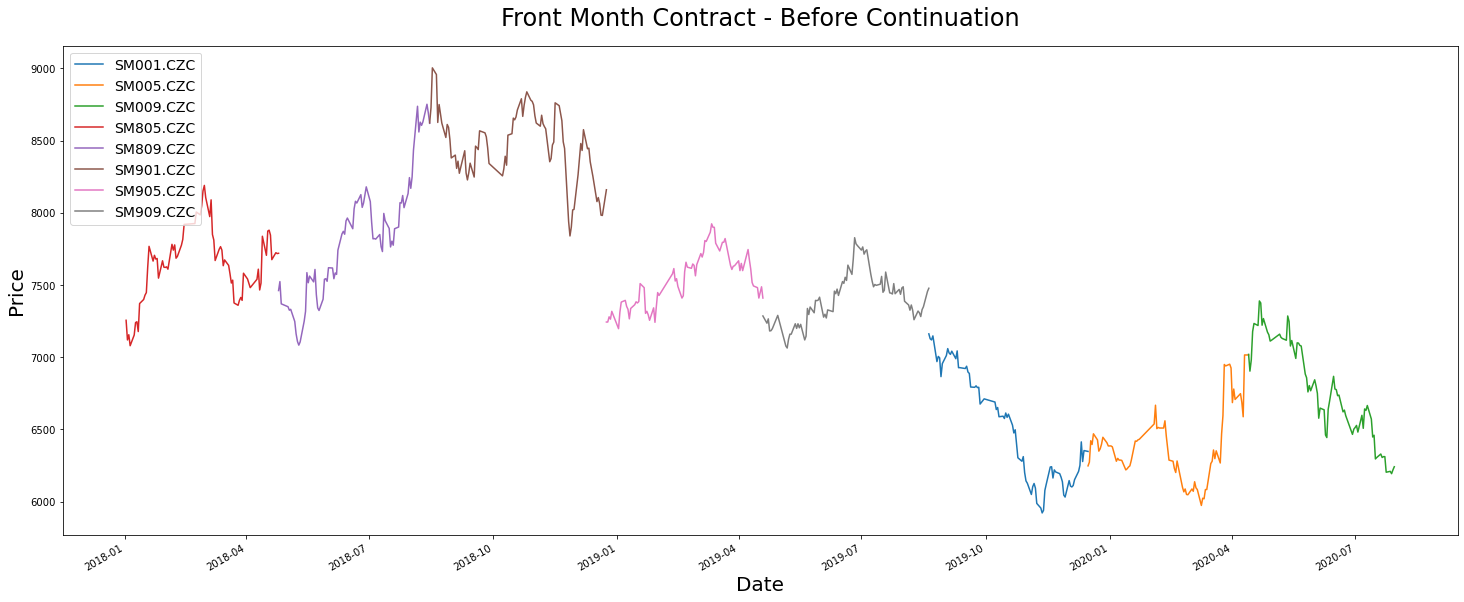

In [149]:
ax3 = AG_P.plot(figsize=(25,10))  ##拼接前
ax3.set_xlabel("Date",fontdict={'fontsize':20})
ax3.set_ylabel("Price",fontdict={'fontsize':20})
ax3.legend(loc=2,fontsize=14)
ax3.set_title('Front Month Contract - Before Continuation',pad=20, fontdict={'fontsize':24})

Text(0.5, 1.0, 'Front Month Contract - After Continuation')

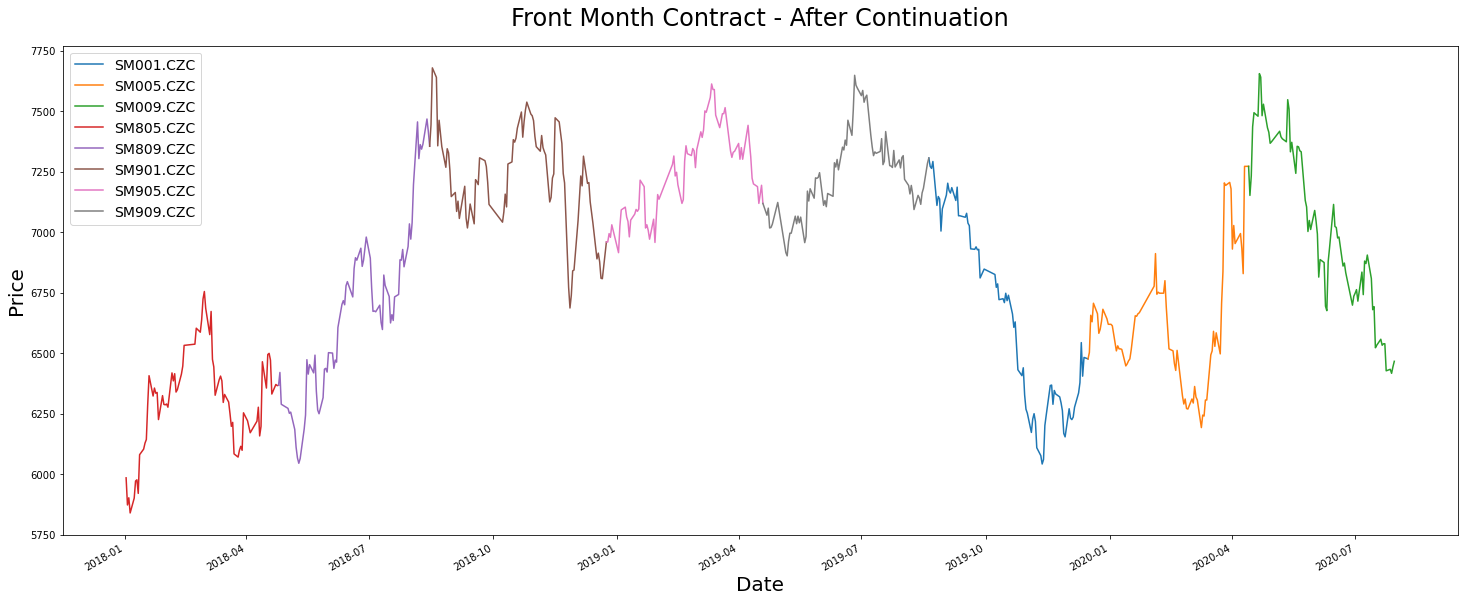

In [157]:
ax4 = AG_S.plot(figsize=(25,10))   ##拼接后
ax4.set_xlabel("Date",fontdict={'fontsize':20})
ax4.set_ylabel("Price",fontdict={'fontsize':20})
ax4.legend(loc=2,fontsize=14)
ax4.set_title('Front Month Contract - After Continuation',pad=20, fontdict={'fontsize':24})

# 6. 构建因子组合

## 6.1 日度数据转化周度数据; 计算仓单，平滑价格 变化率

In [77]:
# 确定数据频率，shift_len = 5时为周度数据（每五个交易日价格变化），lookback = 100控制仓单变化回看期，回看过去100个交易日的变化率
def convert_freq(data, shift_len = 5, lookback = 100):
    # 每隔一周的变化率，修改shift_len控制数据频率
    # 仓单变化率回看期为lookback
    date_list = list(data.ANN_DATE.unique())
    # 计算平滑后价格的变化率SMOOTH_FREQ_RETURN
    data['SMOOTH_FREQ_RETURN'] = data.sort_values(by='ANN_DATE').groupby('fs_info_sccode')['smooth_price'].pct_change(shift_len)
    # 计算仓单数量的变化率 IS——growth
    data['IS_growth'] = data.sort_values(by='ANN_DATE').groupby('fs_info_sccode')['IN_STOCK'].pct_change(lookback)
    # 这里的NAN和inf主要是由于仓单值为0造成的：
    # 从0到0的变化率返回NaN，从0到1的变化率返回inf
    freq_list = [date_list[i] for i in range(max(shift_len,lookback), len(date_list), shift_len)]
    fre_data = data[data.ANN_DATE.isin(freq_list)]
    return fre_data

In [78]:
weekly_data = convert_freq(finished_data, shift_len = 5, lookback = 100)
weekly_data

,ANN_DATE,FS_INFO_SCNAME,PRICE_VALUE,IN_STOCK,fs_info_sccode,s_info_windcode,past_sccode,s_dq_close,factor,cumu_factor,smooth_price,SMOOTH_FREQ_RETURN,IS_growth
100,2017-06-07,石油沥青,2364.0,199470.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,3005.526459,0.009394,-0.297814
105,2017-06-14,石油沥青,2326.0,191390.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,2957.214274,-0.016074,-0.325759
110,2017-06-21,石油沥青,2266.0,182440.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,2880.931876,-0.025795,-0.334476
115,2017-06-28,石油沥青,2302.0,180690.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,2926.701315,0.015887,-0.336966
120,2017-07-05,石油沥青,2368.0,184690.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,3010.611952,0.028671,-0.325506
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26221,2022-11-30,锰硅,7400.0,3423.0,SM,SM301.CZC,NaN,NaN,0.988624,0.988624,7315.817985,0.044313,-0.856321
26226,2022-12-07,锰硅,7456.0,4483.0,SM,SM301.CZC,NaN,NaN,0.988624,0.988624,7371.180932,0.007568,-0.822357
26231,2022-12-14,锰硅,7728.0,4487.0,SM,SM301.CZC,NaN,NaN,0.988624,0.988624,7640.086674,0.036481,-0.817267
26236,2022-12-21,锰硅,7300.0,4345.0,SM,SM305.CZC,SM301.CZC,7384.0,0.988624,1.000000,7300.000000,-0.044513,-0.813655


## 6.2 将仓单数据按照变化率分组 - IS_group
### 处理inf：将inf视作outlier（NaN），在分组时不计入其中，因此因子收益率不考虑上一期仓单变化率为inf的期货

In [79]:
IS_growth_pivot = weekly_data.pivot(index = 'ANN_DATE',
                                    columns = 'fs_info_sccode', values = 'IS_growth').reset_index()
# 处理inf
IS_growth_pivot.replace(np.inf, np.nan, inplace = True)
IS_growth_pivot

fs_info_sccode,ANN_DATE,AG,AL,AU,BU,CF,FG,HC,MA,NI,PB,RB,RM,RU,SM,SN,SR,TA,ZN
0,2017-06-07,-0.231268,10.044730,1.338710,-0.297814,2.070778,-1.000000,NaN,NaN,-0.180923,2.510089,-1.000000,-0.679310,0.371388,86.000000,4.315789,1.019382,0.006308,-0.752973
1,2017-06-14,-0.243218,10.669394,1.896440,-0.325759,1.283237,-1.000000,NaN,-1.000000,-0.177185,1.487002,-0.633622,-0.875098,0.341474,60.000000,0.190906,0.341326,-0.089471,-0.584853
2,2017-06-21,-0.277325,6.814830,2.025890,-0.334476,0.942391,-1.000000,-0.967789,-0.906103,-0.182006,0.528900,-0.964814,-0.865475,0.308811,NaN,0.281656,0.301341,-0.172319,-0.593027
3,2017-06-28,-0.311670,6.763929,-0.212121,-0.336966,0.828829,-1.000000,-0.963611,-0.906103,-0.214708,0.191779,-1.000000,-0.869895,0.276644,NaN,0.638567,0.292025,-0.241357,-0.746911
4,2017-07-05,-0.347100,5.970991,-0.212121,-0.325506,0.686455,-1.000000,-0.565553,-0.905213,-0.215241,0.083910,-1.000000,-0.874786,0.273447,NaN,1.219733,0.271105,-0.293198,-0.808667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2022-11-30,0.186381,-0.654642,-0.031220,-0.942264,-0.969101,-1.000000,-0.290625,-0.208904,0.434830,-0.497105,-0.025414,-1.000000,-0.512212,-0.856321,0.047274,-0.986527,-0.551997,-0.996128
268,2022-12-07,0.280678,-0.640335,0.122044,-0.929287,-0.936123,4.673469,-0.368048,-0.422183,0.216599,-0.542559,-0.064048,-1.000000,-0.485898,-0.822357,0.268237,-0.973461,-0.602699,-0.999642
269,2022-12-14,0.342577,-0.604389,0.280038,-0.855851,-0.909924,17.586207,-0.398513,-0.169635,1.054113,-0.457052,-0.160295,-1.000000,-0.453847,-0.817267,0.541048,-0.964899,-0.410331,-0.996646
270,2022-12-21,0.455006,-0.335447,0.052980,-0.713965,-0.878642,NaN,36.247458,-0.231286,0.412391,-0.239357,-1.000000,NaN,-0.389704,-0.813655,0.363553,-0.904289,-0.529194,-0.965591


In [80]:
# 根据仓单变化率从小到大进行分组，num=10代表一共分10组
def group_by_quantile(data, num = 10):  #num = number of groups to divide
    new = pd.DataFrame(0, index=data.ANN_DATE, columns=data.columns)
    data = data.iloc[:,1:]
    rank = list(range(1,num+1))
    for i in range(data.shape[0]):
        new.iloc[i] = pd.qcut(data.iloc[i].rank(method='first'),num,rank)
    return new.iloc[:,1:]

In [81]:
quantile = group_by_quantile(IS_growth_pivot, num = 5).reset_index()
quantile_data = pd.melt(quantile, id_vars = 'ANN_DATE', var_name='fs_info_sccode', value_name='IN_STOCK_GROUP')
quantile_data

,ANN_DATE,fs_info_sccode,IN_STOCK_GROUP
0,2017-06-07,AG,2.0
1,2017-06-14,AG,2.0
2,2017-06-21,AG,3.0
3,2017-06-28,AG,3.0
4,2017-07-05,AG,2.0
...,...,...,...
4891,2022-11-30,ZN,1.0
4892,2022-12-07,ZN,1.0
4893,2022-12-14,ZN,1.0
4894,2022-12-21,ZN,1.0


In [82]:
week_data = pd.merge(weekly_data, quantile_data, on = ['ANN_DATE','fs_info_sccode'], how = 'inner')
week_data

,ANN_DATE,FS_INFO_SCNAME,PRICE_VALUE,IN_STOCK,fs_info_sccode,s_info_windcode,past_sccode,s_dq_close,factor,cumu_factor,smooth_price,SMOOTH_FREQ_RETURN,IS_growth,IN_STOCK_GROUP
0,2017-06-07,石油沥青,2364.0,199470.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,3005.526459,0.009394,-0.297814,2.0
1,2017-06-14,石油沥青,2326.0,191390.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,2957.214274,-0.016074,-0.325759,2.0
2,2017-06-21,石油沥青,2266.0,182440.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,2880.931876,-0.025795,-0.334476,2.0
3,2017-06-28,石油沥青,2302.0,180690.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,2926.701315,0.015887,-0.336966,2.0
4,2017-07-05,石油沥青,2368.0,184690.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,3010.611952,0.028671,-0.325506,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,2022-11-30,锰硅,7400.0,3423.0,SM,SM301.CZC,NaN,NaN,0.988624,0.988624,7315.817985,0.044313,-0.856321,2.0
4892,2022-12-07,锰硅,7456.0,4483.0,SM,SM301.CZC,NaN,NaN,0.988624,0.988624,7371.180932,0.007568,-0.822357,2.0
4893,2022-12-14,锰硅,7728.0,4487.0,SM,SM301.CZC,NaN,NaN,0.988624,0.988624,7640.086674,0.036481,-0.817267,2.0
4894,2022-12-21,锰硅,7300.0,4345.0,SM,SM305.CZC,SM301.CZC,7384.0,0.988624,1.000000,7300.000000,-0.044513,-0.813655,2.0


### 6.2.1 在实际操作中，只能用过去一期的仓单变化率来解释当前一期的期货价格涨跌幅，所以应该将 IN_STOCK_GROUP 数据整体下移一期，再进行分组观察期货价格，否则会使用未来数据

例如，某期货在第20周的的变化率只能被第19周得出的仓单变化率解释。

In [83]:
week_data['IN_STOCK_GROUP'] = week_data.groupby('fs_info_sccode')['IN_STOCK_GROUP'].shift(1)
week_data = week_data[week_data['IN_STOCK_GROUP'].isna() == False]
week_data

,ANN_DATE,FS_INFO_SCNAME,PRICE_VALUE,IN_STOCK,fs_info_sccode,s_info_windcode,past_sccode,s_dq_close,factor,cumu_factor,smooth_price,SMOOTH_FREQ_RETURN,IS_growth,IN_STOCK_GROUP
1,2017-06-14,石油沥青,2326.0,191390.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,2957.214274,-0.016074,-0.325759,2.0
2,2017-06-21,石油沥青,2266.0,182440.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,2880.931876,-0.025795,-0.334476,2.0
3,2017-06-28,石油沥青,2302.0,180690.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,2926.701315,0.015887,-0.336966,2.0
4,2017-07-05,石油沥青,2368.0,184690.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,3010.611952,0.028671,-0.325506,2.0
5,2017-07-12,石油沥青,2452.0,185860.0,BU,BU1709.SHF,NaN,NaN,1.035878,1.271373,3117.407308,0.035473,-0.322618,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,2022-11-30,锰硅,7400.0,3423.0,SM,SM301.CZC,NaN,NaN,0.988624,0.988624,7315.817985,0.044313,-0.856321,2.0
4892,2022-12-07,锰硅,7456.0,4483.0,SM,SM301.CZC,NaN,NaN,0.988624,0.988624,7371.180932,0.007568,-0.822357,2.0
4893,2022-12-14,锰硅,7728.0,4487.0,SM,SM301.CZC,NaN,NaN,0.988624,0.988624,7640.086674,0.036481,-0.817267,2.0
4894,2022-12-21,锰硅,7300.0,4345.0,SM,SM305.CZC,SM301.CZC,7384.0,0.988624,1.000000,7300.000000,-0.044513,-0.813655,2.0


## 6.3 构建多空组合

### 首先将价格涨跌幅进行去极值处理，再按照分组计算出等权收益率

In [84]:
# 去除极值
# 将每期期货价格涨跌幅高于平均值三个标准差以上的品种剔除
def rm_outliers(df):
    data = pd.DataFrame()
    for date in df.ANN_DATE.unique():
        stocks = df[df['ANN_DATE'] == date]
        mean = stocks.SMOOTH_FREQ_RETURN.mean()
        std = stocks.SMOOTH_FREQ_RETURN.std()
        no_outlier = stocks[(stocks['SMOOTH_FREQ_RETURN']>=(mean-3*std)) 
                            & (stocks['SMOOTH_FREQ_RETURN']<=(mean+3*std))]
        data = pd.concat([data, no_outlier], axis = 0)
    return data
    

# 此前已根据仓案变化率对货品进行分组
# 现在根据分组建立投资组合，upper=9代表选取9、10组，lower=2代表选取1、2组
# 意味着做多仓单下降幅度最大的前20%品种，做空仓单上升幅度最大的 前20%品种
def LSportfolio(data, upper = 9, lower = 2, nooutliers = True):
    if nooutliers:
    #remove outliers
        data = rm_outliers(data)
    #begin to construct portfolios
    date_list = list(data.ANN_DATE.unique())
    factor = pd.DataFrame()
    for dat in date_list:
        Date = data[data.ANN_DATE == dat]
        H_return = Date[Date['IN_STOCK_GROUP'] >= upper].SMOOTH_FREQ_RETURN.mean() #等权平均
        L_return = Date[Date['IN_STOCK_GROUP'] <= lower].SMOOTH_FREQ_RETURN.mean()
        HML =  L_return - H_return  #低仓单 - 高仓单
        new_factor = pd.DataFrame(zip([dat], [HML]), columns = ['ANN_DATE', 'LSportfolio'])
        factor = pd.concat([factor, new_factor])
    factor['cumu_LSportfolio'] = factor.LSportfolio.cumsum()
    return factor


### 6.3.1 仓单因子收益率

In [94]:
cangdan = LSportfolio(week_data, upper = 5, lower = 1, nooutliers = True) #9、10组的等权平均return - 1、2组的等权平均return 的累计收益率

Text(0.5, 1.0, 'Futures Warehouse Receipt Factor')

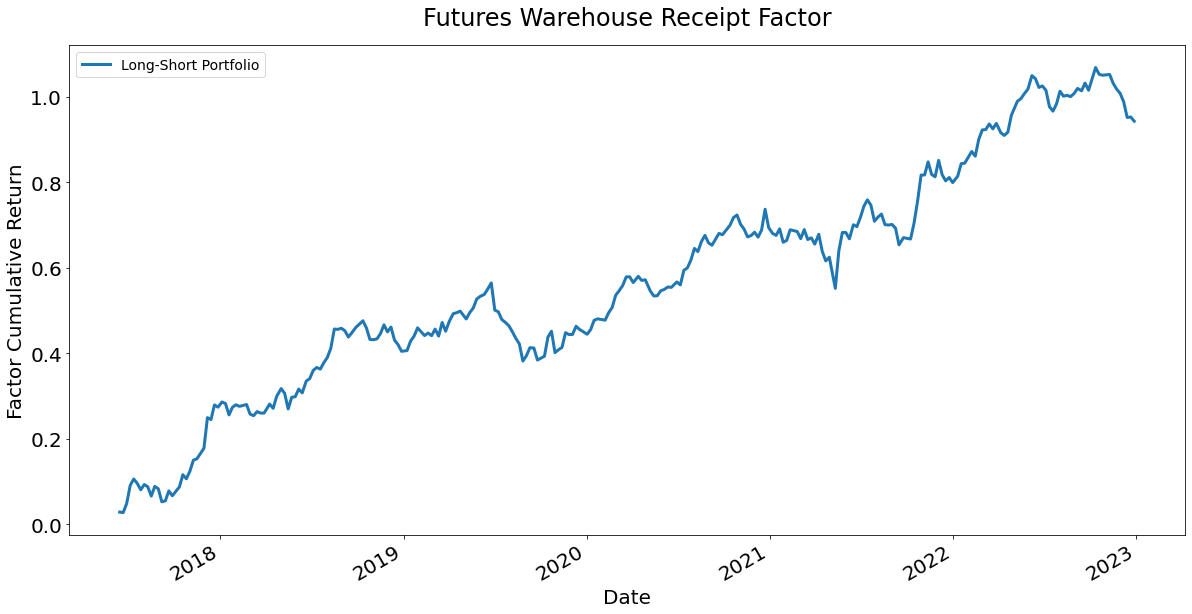

In [148]:
#累计收益率
ax = cangdan.plot(lw = 3, x = 'ANN_DATE', y = 'cumu_LSportfolio',
                  figsize=(20,10), fontsize=20)
ax.set_xlabel("Date",fontdict={'fontsize':20})
ax.set_ylabel("Factor Cumulative Return",fontdict={'fontsize':20})
ax.legend(loc=2,fontsize=14)
ax.legend(['Long-Short Portfolio'],loc=2,fontsize=14)
ax.set_title('Futures Warehouse Receipt Factor',pad=20, fontdict={'fontsize':24})

In [87]:
cangdan = cangdan.rename(columns = {'LSportfolio':'仓单因子收益率','cumu_LSportfolio':'仓单因子累计收益率'})
cangdan

,ANN_DATE,仓单因子收益率,仓单因子累计收益率
0,2017-06-14,0.028591,0.028591
0,2017-06-21,-0.001217,0.027374
0,2017-06-28,0.021524,0.048898
0,2017-07-05,0.042022,0.090920
0,2017-07-12,0.015017,0.105937
...,...,...,...
0,2022-11-30,-0.009874,1.008034
0,2022-12-07,-0.019881,0.988153
0,2022-12-14,-0.036461,0.951692
0,2022-12-21,0.001175,0.952867


### 6.3.2 仓单因子分组排序表现

Text(0.5, 1.0, 'Sorting Warehouse Receipt Factor Portfolio')

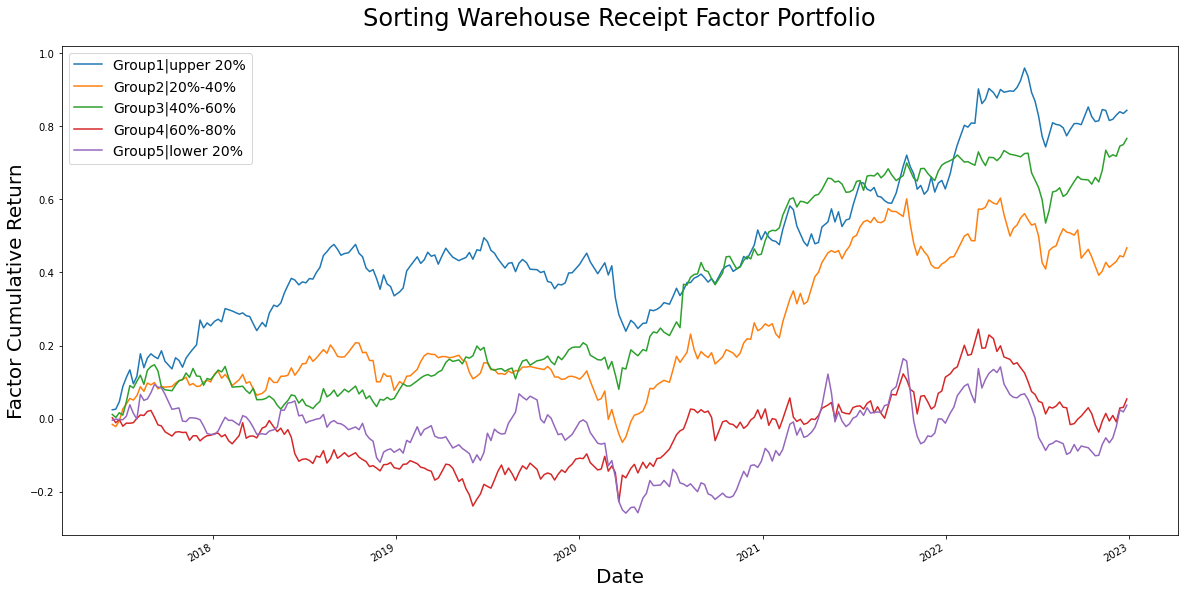

In [115]:
groups = week_data.groupby(['IN_STOCK_GROUP', 'ANN_DATE']).mean().reset_index()
groups['groupcumsum'] = groups.sort_values(
    by='ANN_DATE').groupby('IN_STOCK_GROUP')['SMOOTH_FREQ_RETURN'].cumsum()
groups_pivot = groups.pivot(index = 'ANN_DATE', columns = 'IN_STOCK_GROUP', values = 'groupcumsum')
ax1 = groups_pivot.plot(figsize=(20,10))
ax1.set_xlabel("Date",fontdict={'fontsize':20})
ax1.set_ylabel("Factor Cumulative Return",fontdict={'fontsize':20})
ax1.legend(['Group1|upper 20%','Group2|20%-40%','Group3|40%-60%','Group4|60%-80%','Group5|lower 20%'],loc=2,fontsize=14)
ax1.set_title('Sorting Warehouse Receipt Factor Portfolio',pad=20, fontdict={'fontsize':24})

### 6.3.3 RankIC显示仓单因子在截面回归中可能有效

t-test result for RankIC: Ttest_1sampResult(statistic=-2.2957401483276234, pvalue=0.02245731449735794)
Average RankIC: -0.0369145650768082


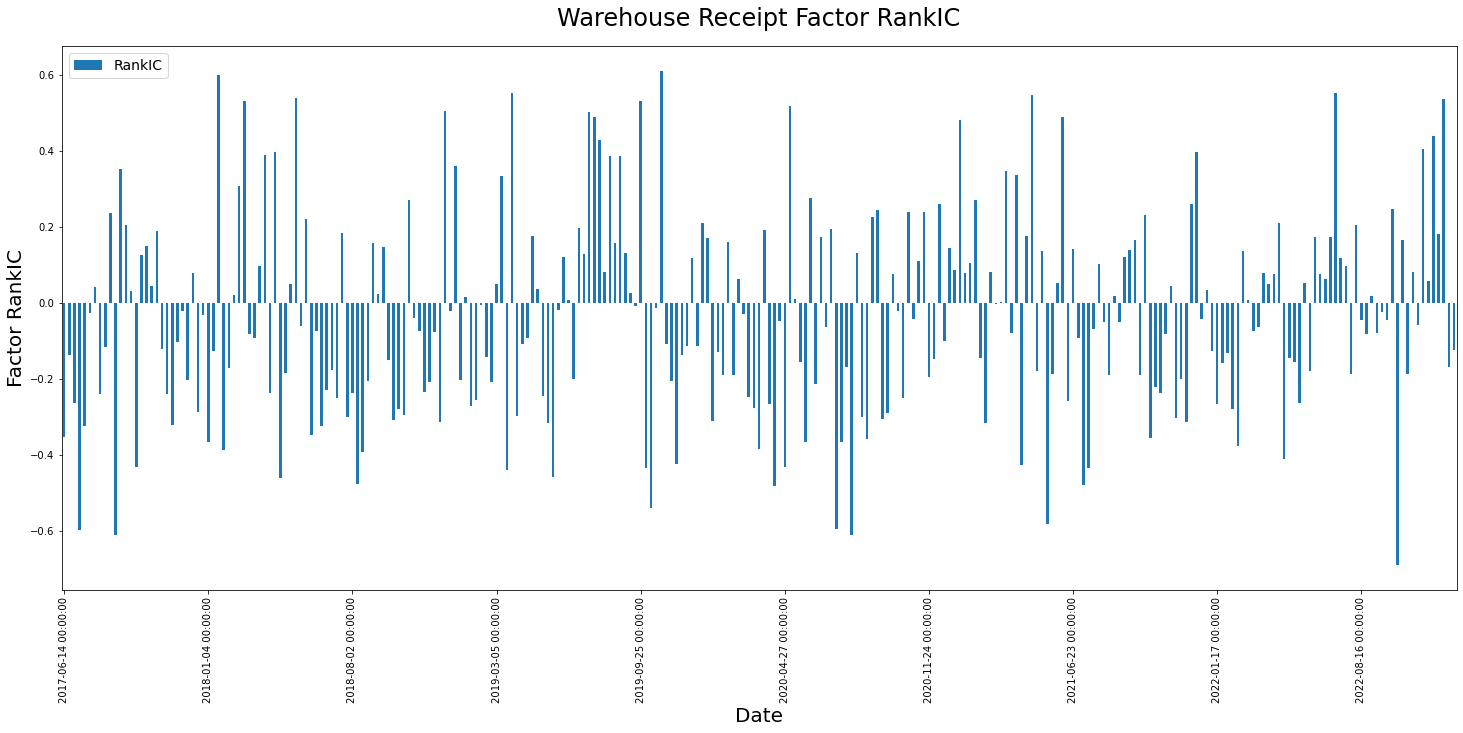

In [129]:
Rank_IC_df = pd.DataFrame(columns = ['ANN_DATE', 'RankIC', 'cumu_RankIC'])
for date in week_data.ANN_DATE.unique():
    future = week_data[week_data['ANN_DATE'] == date]
    RankIC = future.IS_growth.corr(future.SMOOTH_FREQ_RETURN, method="spearman")
    cumu_RankIC = float(RankIC.cumsum())
    RIC_data = [date, RankIC, cumu_RankIC]
    RIC_data = pd.Series(RIC_data, index = Rank_IC_df.columns)
    Rank_IC_df = Rank_IC_df.append(RIC_data, ignore_index=True)

#draw a RankIC time series
ax2 = Rank_IC_df.plot(x = 'ANN_DATE', y = 'RankIC', figsize=(25,10), kind='bar')
ax2.locator_params(axis='x', nbins=10)
ax2.set_xlabel("Date",fontdict={'fontsize':20})
ax2.set_ylabel("Factor RankIC",fontdict={'fontsize':20})
ax2.legend(['RankIC'],loc=2,fontsize=14)
ax2.set_title('Warehouse Receipt Factor RankIC',pad=20, fontdict={'fontsize':24})
print('t-test result for RankIC:', stats.ttest_1samp(a=Rank_IC_df['RankIC'], popmean=0))
print('Average RankIC:', Rank_IC_df.RankIC.mean())

In [90]:
## 通过t检验的p value也可见仓单因子的rankIC显著为负
stats.ttest_1samp(a=Rank_IC_df['RankIC'], popmean=0)

Ttest_1sampResult(statistic=-2.2957401483276234, pvalue=0.02245731449735794)

### 6.3.4 时序线性回归结果不显著

In [91]:
linear = pd.merge(cangdan, week_data[['ANN_DATE','SMOOTH_FREQ_RETURN','fs_info_sccode']],
                  on = ['ANN_DATE'], how = 'inner')
linear

,ANN_DATE,仓单因子收益率,仓单因子累计收益率,SMOOTH_FREQ_RETURN,fs_info_sccode
0,2017-06-14,0.028591,0.028591,-0.016074,BU
1,2017-06-14,0.028591,0.028591,0.041188,RB
2,2017-06-14,0.028591,0.028591,0.032181,SN
3,2017-06-14,0.028591,0.028591,-0.003622,AL
4,2017-06-14,0.028591,0.028591,-0.003947,NI
...,...,...,...,...,...
4599,2022-12-28,-0.009824,0.943042,-0.002198,AU
4600,2022-12-28,-0.009824,0.943042,0.011012,CF
4601,2022-12-28,-0.009824,0.943042,0.012537,TA
4602,2022-12-28,-0.009824,0.943042,-0.001556,MA


In [92]:
ftype = 'MA'
linear_data = linear[linear['fs_info_sccode'] == ftype]
model = sm.OLS(linear_data['SMOOTH_FREQ_RETURN'].astype(float), 
            linear_data[['仓单因子收益率']].values.astype(float))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     SMOOTH_FREQ_RETURN   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.004
Method:                 Least Squares   F-statistic:                             0.2202
Date:                Thu, 27 Apr 2023   Prob (F-statistic):                       0.639
Time:                        09:19:45   Log-Likelihood:                          374.55
No. Observations:                 209   AIC:                                     -747.1
Df Residuals:                     208   BIC:                                     -743.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0587      0.125      0.469      0.639      -0.188       0.305
==============================================================================
Omnibus:                       12.345   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               31.005
Skew:                           0.023   Prob(JB):                     1.85e-07
Kurtosis:                       4.886   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 缺点：
# 1. 回看100天仓单涨跌幅不能代表整体趋势（0 to 0）
# 2. 期货拼接的方式很简易，可能无法完全显示真实收益率
# 3. 向前移动价格的拼接方式需要修改历史数据，不利于维护